In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 50, 50

train_data_dir = 'data/symlinks/train'
validation_data_dir = 'data/symlinks/validation'
test_data_dir = 'data/symlinks/test'
nb_epoch = 10
batch_size=128

In [3]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        samplewise_center=True,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        samplewise_center=True,
        rescale=1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        follow_links=True)

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        follow_links=True)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary',
        follow_links=True)

Found 87874 images belonging to 2 classes.
Found 72289 images belonging to 2 classes.
Found 48224 images belonging to 2 classes.


In [3]:
def get_model():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

model = get_model()

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
__________

In [6]:
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

In [7]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples/batch_size,
        epochs=nb_epoch,
        validation_data=validation_generator,
        verbose=1,
        validation_steps=validation_generator.samples/batch_size,
        workers=8,
        pickle_safe=True,
        callbacks=[history, tensorboard, checkpointer])

Epoch 1/10
687/686 [==============================] - 40s - loss: 0.0857 - acc: 0.9719 - val_loss: 0.0170 - val_acc: 0.9941
Epoch 2/10
687/686 [==============================] - 40s - loss: 0.0308 - acc: 0.9917 - val_loss: 0.0165 - val_acc: 0.9954
Epoch 3/10
687/686 [==============================] - 43s - loss: 0.0258 - acc: 0.9928 - val_loss: 0.0125 - val_acc: 0.9965
Epoch 4/10
687/686 [==============================] - 46s - loss: 0.0204 - acc: 0.9942 - val_loss: 0.0138 - val_acc: 0.9958
Epoch 5/10
687/686 [==============================] - 44s - loss: 0.0203 - acc: 0.9944 - val_loss: 0.0147 - val_acc: 0.9962
Epoch 6/10
687/686 [==============================] - 47s - loss: 0.0168 - acc: 0.9955 - val_loss: 0.0134 - val_acc: 0.9956
Epoch 7/10
687/686 [==============================] - 56s - loss: 0.0168 - acc: 0.9959 - val_loss: 0.0137 - val_acc: 0.9963
Epoch 8/10
687/686 [==============================] - 46s - loss: 0.0153 - acc: 0.9960 - val_loss: 0.0159 - val_acc: 0.9961
Epoch 9/

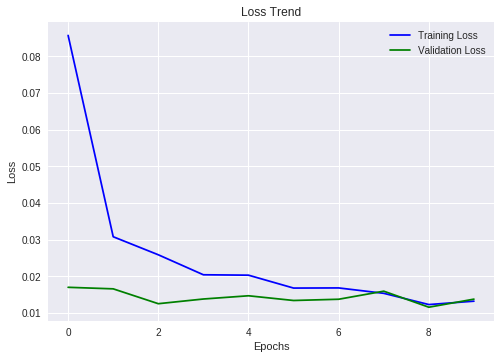

In [9]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()

plt.show()

In [10]:
test_loss, test_acc = model.evaluate_generator(
         test_generator,
         workers=8,
         pickle_safe=True,
         steps=test_generator.samples/batch_size)

print("test_loss: %.4f - test_acc: %.4f"%(test_loss, test_acc))

test_loss: 0.0142 - test_acc: 0.9958


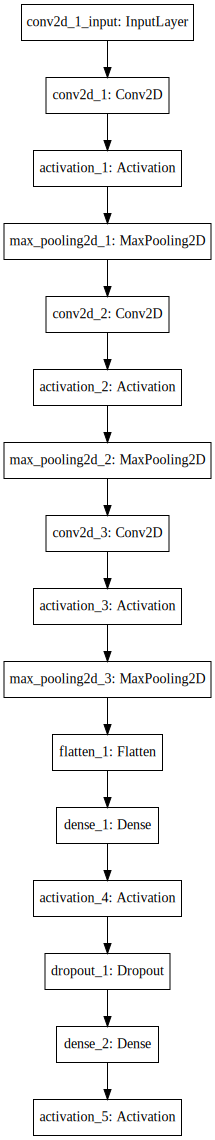

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))